# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import os
import time
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [8]:
azdias['LP_LEBENSPHASE_FEIN'][:100]

0     15.0
1     21.0
2      3.0
3      0.0
4     32.0
5      8.0
6      2.0
7      5.0
8     10.0
9      4.0
10     6.0
11     0.0
12    23.0
13     3.0
14     0.0
15    12.0
16     0.0
17     0.0
18    10.0
19    20.0
20    10.0
21    10.0
22     1.0
23    20.0
24     0.0
25     0.0
26    11.0
27    25.0
28     5.0
29    13.0
      ... 
70    28.0
71    22.0
72     6.0
73     2.0
74     4.0
75     0.0
76    37.0
77    37.0
78    29.0
79    24.0
80    26.0
81     0.0
82    24.0
83    14.0
84     5.0
85    12.0
86    20.0
87    39.0
88    27.0
89     1.0
90     1.0
91    22.0
92    27.0
93    36.0
94    12.0
95     1.0
96     0.0
97     0.0
98    10.0
99     0.0
Name: LP_LEBENSPHASE_FEIN, Length: 100, dtype: float64

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape[0])
print(azdias.shape[1])
azdias.head()

891221
85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(len(feat_info))
print(feat_info.shape[1])
feat_info.head()

85
4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [21]:
azdias[azdias == ''].count()

AGER_TYP                 0
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GEBURTSJAHR              0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
KBA05_ANTG1              0
K

In [20]:
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [3]:
# convert feat_info to a dictionary **********
feat_dict = feat_info[['attribute','missing_or_unknown']].set_index('attribute').T.to_dict('list')

# change the value from string to a list
for k,v in feat_dict.items():
    feat_dict[k] = v[0][1: -1].split(',')
    
print(feat_dict)

{'AGER_TYP': ['-1', '0'], 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'], 'ANREDE_KZ': ['-1', '0'], 'CJT_GESAMTTYP': ['0'], 'FINANZ_MINIMALIST': ['-1'], 'FINANZ_SPARER': ['-1'], 'FINANZ_VORSORGER': ['-1'], 'FINANZ_ANLEGER': ['-1'], 'FINANZ_UNAUFFAELLIGER': ['-1'], 'FINANZ_HAUSBAUER': ['-1'], 'FINANZTYP': ['-1'], 'GEBURTSJAHR': ['0'], 'GFK_URLAUBERTYP': [''], 'GREEN_AVANTGARDE': [''], 'HEALTH_TYP': ['-1', '0'], 'LP_LEBENSPHASE_FEIN': ['0'], 'LP_LEBENSPHASE_GROB': ['0'], 'LP_FAMILIE_FEIN': ['0'], 'LP_FAMILIE_GROB': ['0'], 'LP_STATUS_FEIN': ['0'], 'LP_STATUS_GROB': ['0'], 'NATIONALITAET_KZ': ['-1', '0'], 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'], 'RETOURTYP_BK_S': ['0'], 'SEMIO_SOZ': ['-1', '9'], 'SEMIO_FAM': ['-1', '9'], 'SEMIO_REL': ['-1', '9'], 'SEMIO_MAT': ['-1', '9'], 'SEMIO_VERT': ['-1', '9'], 'SEMIO_LUST': ['-1', '9'], 'SEMIO_ERL': ['-1', '9'], 'SEMIO_KULT': ['-1', '9'], 'SEMIO_RAT': ['-1', '9'], 'SEMIO_KRIT': ['-1', '9'], 'SEMIO_DOM': ['-1', '9'], 'SEMIO_KAEM': ['-1', '9'], 'SEMIO_PFLICHT': 

In [4]:
### Identify missing or unknown data values in azdias according to feat_dict ********
# azdias.isin({'AGER_TYP': ['-1', 0], 'ALTERSKATEGORIE_GROB': ['2', '0', '9']})
azdias_rep_na = azdias.isin(feat_dict)
print('check finish')

check finish


In [7]:
### check the azdias_rep_na dataframe
azdias_rep_na[azdias_rep_na==True].count()  # can also be: azdias_rep_na[azdias_rep_na].count()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP                 0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP               0
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       92778
LP_LEBENSPHASE_GROB       89718
LP_FAMILIE_FEIN           72938
LP_FAMILIE_GROB           72938
LP_STATUS_FEIN                0
LP_STATUS_GROB                0
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [5]:
### Convert missing or unknown data values to NaNs.******
azdias_rep_na[azdias_rep_na==True] = np.NaN
azdias_rep_na[azdias_rep_na==False] = azdias

print("finish replacing missing data with NaN")

finish replacing missing data with NaN


In [6]:
### 按照列统计每列含NaNs的个数 ********
azdias_na_sum = azdias_rep_na.isna().sum().to_frame()
azdias_na_sum[0:5]

,0
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

### rename the sum of NaN column
azdias_na_sum.columns = ['nan_sum']
azdias_na_sum.head()

,nan_sum
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0


In [8]:
### sort by nan_sum to get the features which have most missing data at the top. 
azdias_na_sort = azdias_na_sum.sort_values(['nan_sum'], ascending=0)
azdias_na_sort[0:5]

,nan_sum
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318


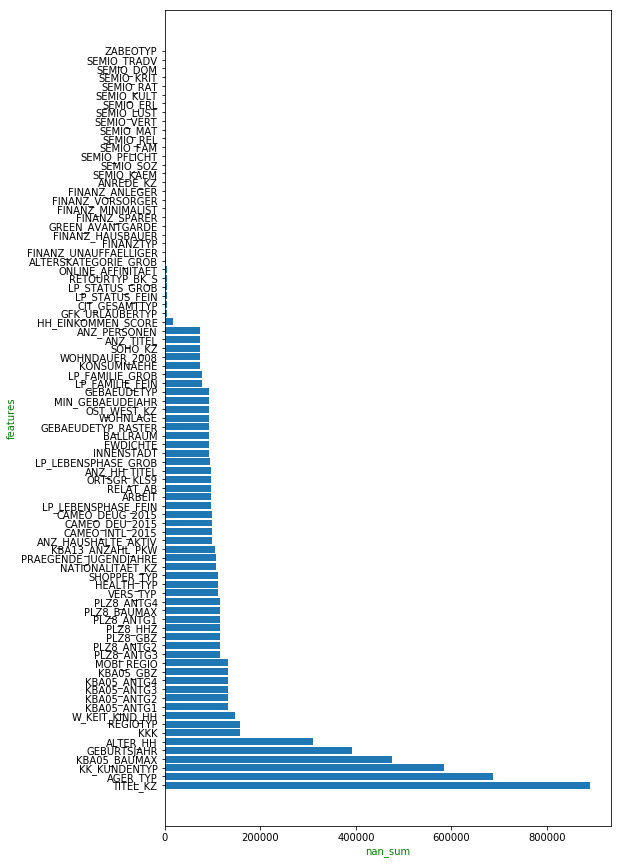

In [48]:
### draw a bar chart to see how much missing data there is in each column in order

ax = plt.figure(figsize=(8,15))
#ax = plt.figure()

# 数据
x = azdias_na_sort['nan_sum']
y = azdias_na_sort.index


# 绘图 x= 起始位置， bottom= 水平条的底部(左侧), y轴， height 水平条的宽度， width 水平条的长度
#p1 = plt.bar(x=0, bottom=y, height=0.5, width=x, orientation="horizontal")

# 绘图 y= y轴， left= 水平条的底部， height 水平条的宽度， width 水平条的长度
plt.yticks(np.arange(len(y)), y)
plt.barh(np.arange(len(y)), left=0, height=0.8, width=x)
plt.xlabel('nan_sum',color='g')
plt.ylabel('features',color='g')

# 展示图形
plt.show()

In [10]:
azdias_na_sort.index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO',
       'PLZ8_ANTG3', 'PLZ8_ANTG2', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_ANTG1',
       'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'VERS_TYP', 'HEALTH_TYP', 'SHOPPER_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'ARBEIT', 'RELAT_AB',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'OST_WEST_KZ',
       'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'KONSUMNAEHE', 'WOHNDAUER_2008', 'SOHO_KZ', 'ANZ_TITEL', 'ANZ_PERSONEN',
       'HH_EINKOMMEN_SCORE', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP',
       'LP_STATUS_FEIN', 'LP_STA

In [11]:
feature_top = azdias_rep_na.loc[:,['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']]
feature_top.head()

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH,KKK,REGIOTYP,W_KEIT_KIND_HH,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,5,1996,NaN,2,3,3,0,0,0,2,1,1
2,NaN,NaN,NaN,NaN,1979,17,2,2,3,1,3,1,0,3,3
3,NaN,2,NaN,1,1957,13,NaN,NaN,NaN,4,1,0,0,4,4
4,NaN,NaN,1,NaN,1963,20,3,5,2,1,4,1,0,3,3


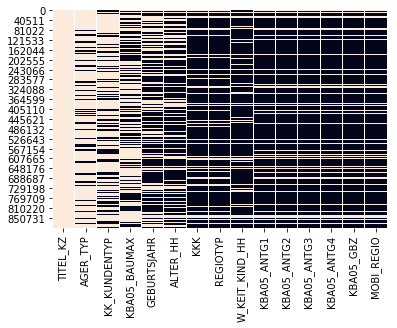

In [33]:
### Investigate patterns in the amount of missing data in each column.

sns.heatmap(feature_top.isna(), cbar=False)


In [34]:
feature_x = azdias_rep_na.loc[:,['AGER_TYP']]
feature_x.head()

,AGER_TYP
0,NaN
1,NaN
2,NaN
3,2
4,NaN


(array([ 0.46089129,  1.53910871]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)


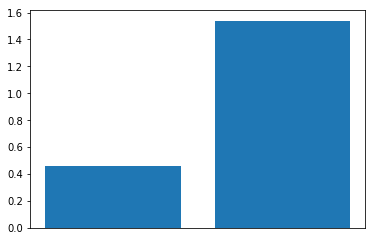

In [49]:
n = plt.hist(feature_x.isna(), bins=2, normed=True, rwidth=0.8, cumulative=False)     # normed=True是频率图，默认是频数图
print(n)

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.) *********

df_rows = azdias.iloc[:,0].size

df_na_column = azdias_rep_na.isna().sum().to_frame()
df_na_column.columns = ['nan_sum']

# 选出20%以上都是空值的列的名字
drop_na_index = df_na_column.loc[df_na_column['nan_sum'] > df_rows * 0.20].index
# 在写函数的时候需要指定要删除的列，否则与customers data要删的字段可能不统一了。
print('These columns have too much missing data: ')
print(drop_na_index)

These columns have too much missing data: 
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [14]:
azdias2 = azdias_rep_na.drop(drop_na_index, axis=1)
azdias2.shape

(891221, 79)

In [17]:
azdias_rep_na.shape

(891221, 85)

In [25]:
print('Drop these columns...and the df shape become: {0}'.format(azdias2.shape))

Drop these columns...and the df shape become: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

I sorted the columns by the number of their missing values, and draw a bar chart to see the columns by their missing value. I found there are 6 columns which have more than 34% missing values. So I remove the top 6 columns from the dataset. Start from 'KKK', the missing value proportion sharply decreases to 17.74% and many other columns have the similiar ratio, so I keep them. 

Another pattern is I notice some rows have most NaN value in almost all columns from the heatmap, I need to remove them later.

- **TITEL_KZ	889061   99.76%**
- **AGER_TYP	685843**
- **KK_KUNDENTYP	584612**
- **KBA05_BAUMAX	476524**
- **GEBURTSJAHR	392318**
- **ALTER_HH	310267   34.81%**
- KKK	158064   17.74%
- REGIOTYP	158064

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
#### How much data is missing in each row of the dataset? ************

azdias2_na_row = azdias2.isna().sum(axis=1)
azdias2_na_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [16]:
### sort the azdias2_na_row(Series) by the number of missing data in each row.
azdias2_na_row_sort = azdias2_na_row.sort_values(ascending=False)
azdias2_na_row_sort.head()

643174    49
732775    49
472919    48
183108    47
139316    47
dtype: int64

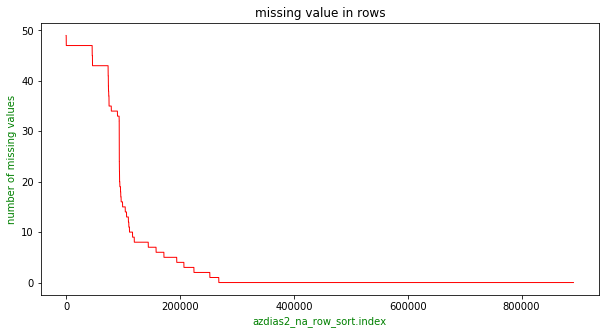

In [39]:
### draw a line chart to see the distribution of missing data in rows ---to determine the threshold

ax = plt.figure(figsize=(10,5))

# 数据
# x = azdias2_na_row_sort.index  #直接用index，顺序会乱，画出来的图很奇怪
x = np.arange(len(azdias2_na_row_sort.index))
y = azdias2_na_row_sort.values

# 绘图 
#plt.xticks(np.arange(len(x)), x) #这里不用保留原来row的index
plt.plot(x,y,"r",linewidth=1)
plt.xlabel('azdias2_na_row_sort.index',color='g')
plt.ylabel('number of missing values',color='g')
plt.title("missing value in rows") #标题

# 展示图形
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row. ***************

threshold = 20

# get the index that NaN >= threshold
subset1_index = azdias2_na_row[azdias2_na_row.values >= threshold].index
print(subset1_index[0:10])

# get the index that NaN < threshold
subset2_index = azdias2_na_row[azdias2_na_row.values < threshold].index
print(subset2_index[0:10])

# create subset1
subset1 = azdias2.loc[subset1_index,:]
print(subset1.shape)

# create subset2
subset2 = azdias2.loc[subset2_index,:]
print(subset2.shape)

Int64Index([0, 11, 14, 17, 24, 30, 35, 46, 48, 53], dtype='int64')
Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')
(94144, 79)
(797077, 79)


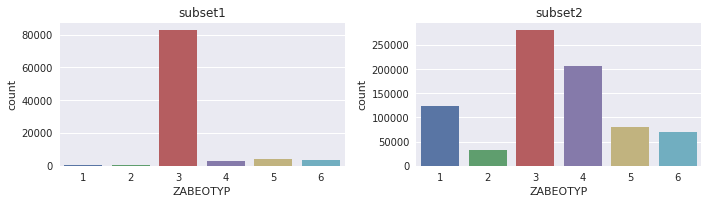

In [14]:
###### Compare the distribution of values for at least five columns where there are
###### no or few missing values, between the two subsets. 

### according to azdias_na_sort.index, the last 5 columns which have least missing value are: 
### 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_TRADV', 'ZABEOTYP'

# 尝试画出对比图，后面会转化成函数
plt.figure(figsize=(10, 3))
sns.set(style="darkgrid")

# draw subset1
ax1=plt.subplot(1, 2, 1)
ax1.set_title('subset1')
ax1 = sns.countplot(x="ZABEOTYP", data=subset1)

# draw subset2
ax2=plt.subplot(1, 2, 2)
ax2.set_title('subset2')
ax2 = sns.countplot(x="ZABEOTYP", data=subset2)

plt.tight_layout()
plt.show()


In [9]:
def compare_countplot(column, dataset1, dataset2):
    plt.figure(figsize=(10, 3))

    sns.set(style="darkgrid")

    # draw subset1
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('dataset1')
    ax1 = sns.countplot(x=column, data=dataset1)

    # draw subset2
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('dataset2')
    ax2 = sns.countplot(x=column, data=dataset2)

    plt.tight_layout()
    plt.show()

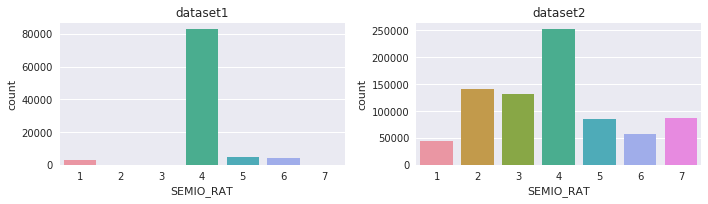

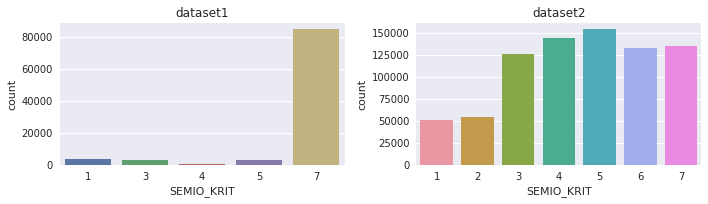

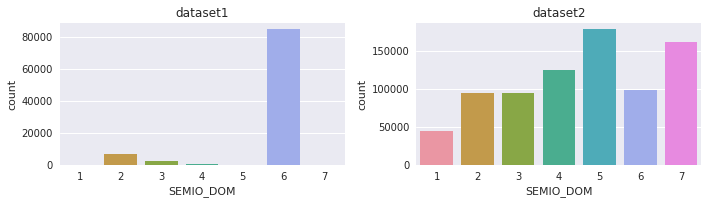

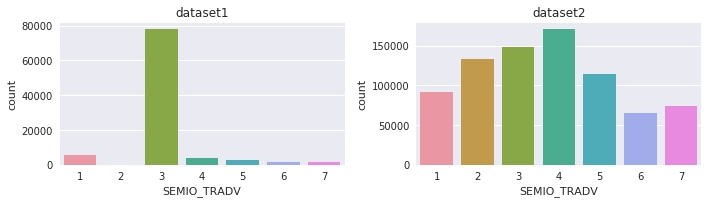

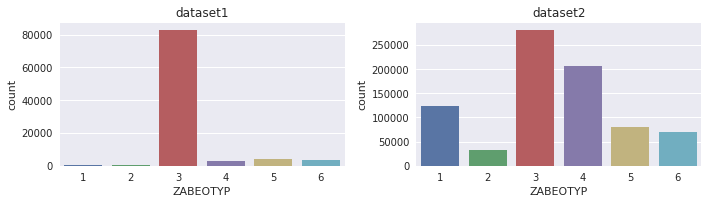

finish


In [10]:
compare_list = ['SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_TRADV', 'ZABEOTYP']
#compare_list =['FINANZ_MINIMALIST', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'ANREDE_KZ',
#       'SEMIO_KAEM', 'SEMIO_SOZ', 'SEMIO_PFLICHT', 'SEMIO_FAM', 'SEMIO_REL',
#       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
#       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_TRADV', 'ZABEOTYP']
for i in range(len(compare_list)):
    column_name = compare_list[i]
    compare_countplot(column_name, subset1, subset2)
    
print('finish')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

I have compared the last 19 columns which have the least missing values, and found the distributions of data with lots of missing values are very different from data with few or no missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
###### How many features are there of each data type? ************************

#打出df各列数据类型，并利用rest_index()转成DataFrame形式。一共两列，1-列名，2-类型
azdias_types = azdias.dtypes.reset_index()  

#将两列更改列名
azdias_types.columns = ["columns", "Column Type"]

#分组统计各个类型列出现的次数
azdias_types_group=azdias_types.groupby("Column Type").aggregate('count').reset_index()
azdias_types_group

,Column Type,columns
0,int64,32
1,float64,49
2,object,4


In [22]:
# 统计feature说明里，各种类型的feature有多少个
feat_info_type = feat_info.groupby("type").aggregate('count').reset_index()
feat_info_type

,type,attribute,information_level,missing_or_unknown
0,categorical,21,21,21
1,interval,1,1,1
2,mixed,7,7,7
3,numeric,7,7,7
4,ordinal,49,49,49


In [69]:
feat_info[feat_info['type'] == 'categorical']  # 要处理的Categorical类型的feature

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [42]:
azdias_types[azdias_types["Column Type"] == 'object']  # 哪些是object

,columns,Column Type
55,OST_WEST_KZ,object
57,CAMEO_DEUG_2015,object
58,CAMEO_DEU_2015,object
59,CAMEO_INTL_2015,object


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
### copy subset 2 to a new df ***************
subset2_encode = subset2.copy()

In [24]:
# Function of One-hot encoding one column ************

def one_hot_data(df, column_name):
    # Make dummy variables for column_name
    one_hot_data = pd.concat([df, pd.get_dummies(df[column_name], prefix=column_name)], axis=1)

    # Drop the column_name column
    one_hot_data = one_hot_data.drop(column_name, axis=1)
    
    return one_hot_data


In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Re-encode categorical variable(s) to be kept in the analysis.   ********************************

max_onehot_len = 4

categorical_index = feat_info[feat_info['type'] == 'categorical']['attribute'].values

for i in categorical_index:
    # 确保categorical的列在我们要处理的df里面（因为前面裁剪过df）
    if i in subset2_encode.columns:
        
        # 判断是否存在空值，且只有1个类型值
        if subset2_encode[i].isna().any() and len(subset2_encode[i].unique()) <= 2:
            # Drop the column（如果一个categorical特征只有一种值，没有意义）
            subset2_encode = subset2_encode.drop(i, axis=1)
            print('Drop the column due to only one value: %s' %i)
            continue
            
        # 判断是否是binary (two-level) categoricals
        elif (subset2_encode[i].isna().any() and len(subset2_encode[i].unique()) == 3) \
        or (subset2_encode[i].isna().any() == False and len(subset2_encode[i].unique()) == 2):
                
                # 判断是否数值型变量（binary variable that have numeric values）
                if azdias_types[azdias_types['columns']  == i]['Column Type'].values != 'object':
                    print('Ignore the numeric binary column: %s' %i)
                    continue
                    
                # 非数值型二值变量（binary variable that takes on non-numeric values）
                else:
                    subset2_encode = one_hot_data(subset2_encode, i)
                    print('Re-encode the non-numeric binary column with OneHot: %s' %i)
                    continue
                    
        elif len(subset2_encode[i].unique()) > max_onehot_len:
            # Drop the column（如果一个categorical特征有太多种值，one-hot后会使得变量数量太多）
            subset2_encode = subset2_encode.drop(i, axis=1)
            print('Drop the column due to too many values: %s' %i)
            continue
            
        # 只针对类型值在某个范围内的变量做one-hot处理
        elif len(subset2_encode[i].unique()) <= max_onehot_len:
            subset2_encode = one_hot_data(subset2_encode, i)
            print('Re-encode the multiple value column with OneHot: %s' %i)
            continue
            
    else:
        continue
            
            
subset2_encode.head()

Ignore the numeric binary column: ANREDE_KZ
Drop the column due to too many values: CJT_GESAMTTYP
Drop the column due to too many values: FINANZTYP
Drop the column due to too many values: GFK_URLAUBERTYP
Ignore the numeric binary column: GREEN_AVANTGARDE
Drop the column due to too many values: LP_FAMILIE_FEIN
Drop the column due to too many values: LP_FAMILIE_GROB
Drop the column due to too many values: LP_STATUS_FEIN
Drop the column due to too many values: LP_STATUS_GROB
Re-encode the multiple value column with OneHot: NATIONALITAET_KZ
Drop the column due to too many values: SHOPPER_TYP
Ignore the numeric binary column: SOHO_KZ
Ignore the numeric binary column: VERS_TYP
Drop the column due to too many values: ZABEOTYP
Drop the column due to too many values: GEBAEUDETYP
Re-encode the non-numeric binary column with OneHot: OST_WEST_KZ
Drop the column due to too many values: CAMEO_DEUG_2015
Drop the column due to too many values: CAMEO_DEU_2015


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W
1,1,2,1,5,2,5,4,5,0,3,...,5,4,3,5,4,1,0,0,0,1
2,3,2,1,4,1,2,3,5,1,3,...,4,4,3,5,2,1,0,0,0,1
3,4,2,4,2,5,2,1,2,0,2,...,3,4,2,3,3,1,0,0,0,1
4,3,1,4,3,4,1,3,2,0,3,...,3,3,4,6,5,1,0,0,0,1
5,1,2,3,1,5,2,2,5,0,3,...,5,5,2,3,3,1,0,0,0,1


In [83]:
categorical_index

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [122]:
# check whether columns have been dropped successfully
subset2_encode.columns 

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I deal with the following Categorical Features which are included in the subset2 (subset from 1.1.3 about missing data):
- Ignore the numeric binary column: ANREDE_KZ
- Drop the column due to too many values: CJT_GESAMTTYP
- Drop the column due to too many values: FINANZTYP
- Drop the column due to too many values: GFK_URLAUBERTYP
- Ignore the numeric binary column: GREEN_AVANTGARDE
- Drop the column due to too many values: LP_FAMILIE_FEIN
- Drop the column due to too many values: LP_FAMILIE_GROB
- Drop the column due to too many values: LP_STATUS_FEIN
- Drop the column due to too many values: LP_STATUS_GROB
- Re-encode the multiple value column with OneHot: NATIONALITAET_KZ
- Drop the column due to too many values: SHOPPER_TYP
- Ignore the numeric binary column: SOHO_KZ
- Ignore the numeric binary column: VERS_TYP
- Drop the column due to too many values: ZABEOTYP
- Drop the column due to too many values: GEBAEUDETYP
- Re-encode the non-numeric binary column with OneHot: OST_WEST_KZ
- Drop the column due to too many values: CAMEO_DEUG_2015
- Drop the column due to too many values: CAMEO_DEU_2015

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [129]:
# check the mixed-type features we are going to deal with
feat_info.loc[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [27]:
# 查看某一列的情况
column_name = 'PRAEGENDE_JUGENDJAHRE'

print('Unique values: %s' %subset2_encode[column_name].unique()) 

if azdias_types[azdias_types['columns']  == column_name]['Column Type'].values == 'object':
    print('type is object')

Unique values: [14 15 8 3 10 11 5 9 6 4 nan 2 1 12 13 7]


In [25]:
type(subset2_encode)

pandas.core.frame.DataFrame

In [26]:
# Load in the mix_feature_PRAEGENDE_JUGENDJAHRE mapping file ***********
Mix_PJ_map = pd.read_csv('mix_feature_PRAEGENDE_JUGENDJAHRE.csv', sep = ',')

In [29]:
### 用test数据集尝试方案
test = subset2_encode.copy().loc[:1000]
test = test.loc[:, ('PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015')]

### add "decade" column
decade = test['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['decade'].values)
decade = decade.applymap(lambda x: x[0] if x else np.NaN)
decade.rename(columns={'PRAEGENDE_JUGENDJAHRE':'decade'}, inplace = True)
test = pd.concat([test, decade], axis = 1, ignore_index = False)

### add "movement" column
movement = test['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['movement'].values)
movement = movement.applymap(lambda x: x[0] if x else 0 if x ==0 else np.NaN)
movement.rename(columns={'PRAEGENDE_JUGENDJAHRE':'movement'}, inplace = True)
test = pd.concat([test, movement], axis = 1, ignore_index = False)
  
### add "wealth" column
wealth = test['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if pd.isna(x) else int(int(x)/10))
#wealth = test['CAMEO_INTL_2015'].to_frame().applymap(f)
wealth.rename(columns={'CAMEO_INTL_2015':'wealth'}, inplace = True)
test = pd.concat([test, wealth], axis = 1, ignore_index = False)


### add "life_stage" column
life_stage = test['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if pd.isna(x) else int(int(x)%10))
#life_stage = test['CAMEO_INTL_2015'].to_frame().applymap(f)
life_stage.rename(columns={'CAMEO_INTL_2015':'life_stage'}, inplace = True)
test = pd.concat([test, life_stage], axis = 1, ignore_index = False)

print(test.shape)

(841, 6)


In [30]:
print(test[:10])

   PRAEGENDE_JUGENDJAHRE CAMEO_INTL_2015  decade  movement  wealth  life_stage
1                     14              51    90.0       0.0     5.0         1.0
2                     15              24    90.0       1.0     2.0         4.0
3                      8              12    70.0       0.0     1.0         2.0
4                      8              43    70.0       0.0     4.0         3.0
5                      3              54    50.0       0.0     5.0         4.0
6                     10              22    80.0       0.0     2.0         2.0
7                      8              14    70.0       0.0     1.0         4.0
8                     11              13    80.0       1.0     1.0         3.0
9                     15              15    90.0       1.0     1.0         5.0
10                     3              51    50.0       0.0     5.0         1.0


In [ ]:
##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables. 

subset2_engmixed = subset2_encode.copy()

### add "decade" column  applymap会把df里的每个元素，apply后面的function。
# lambda里的x代表df里的每个元素的值，根据Mix_PJ_map里定义好的mapping规则找到需要转化的值，返回
decade = subset2_engmixed['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['decade'].values)
decade = decade.applymap(lambda x: x[0] if x else np.NaN)
decade.rename(columns={'PRAEGENDE_JUGENDJAHRE':'decade'}, inplace = True)
subset2_engmixed = pd.concat([subset2_engmixed, decade], axis = 1, ignore_index = False)

### add "movement" column
movement = subset2_engmixed['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['movement'].values)
movement = movement.applymap(lambda x: x[0] if x else 0 if x ==0 else np.NaN)
movement.rename(columns={'PRAEGENDE_JUGENDJAHRE':'movement'}, inplace = True)
subset2_engmixed = pd.concat([subset2_engmixed, movement], axis = 1, ignore_index = False)

# drop orignal column
subset2_engmixed = subset2_engmixed.drop('PRAEGENDE_JUGENDJAHRE', axis=1)


In [23]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### add "wealth" column
wealth = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if x is np.NaN else int(int(x)/10))
#wealth = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(f)
wealth.rename(columns={'CAMEO_INTL_2015':'wealth'}, inplace = True)
subset2_engmixed = pd.concat([subset2_engmixed, wealth], axis = 1, ignore_index = False)


### add "life_stage" column
life_stage = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if x is np.NaN else int(int(x)%10))
#wealth = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(f)
life_stage.rename(columns={'CAMEO_INTL_2015':'life_stage'}, inplace = True)
subset2_engmixed = pd.concat([subset2_engmixed, life_stage], axis = 1, ignore_index = False)


# drop orignal column
subset2_engmixed = subset2_engmixed.drop('CAMEO_INTL_2015', axis=1)

subset2_engmixed.head()
subset2_engmixed.shape

    

Unique values: ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
type is object


In [ ]:
# dropped these mixed columns due to they cannot be clearly seperated to new categories:
subset2_engmixed = subset2_engmixed.drop('LP_LEBENSPHASE_FEIN', axis=1)
subset2_engmixed = subset2_engmixed.drop('LP_LEBENSPHASE_GROB', axis=1)
subset2_engmixed.shape

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I translate these 2 columns to new features:
- PRAEGENDE_JUGENDJAHRE
    - created a mapping table for mapping the value to 2 new categories.
    - use .applymap and lambda function to create new categories
    - append the new columns back to the dataset
    - drop the original column
- CAMEO_INTL_2015
    - easier than PRAEGENDE_JUGENDJAHRE, create 2 new categories by calculate from the mixed feature
    - also append the new columns back to the dataset
    - drop the original column

I dropped these columns due to they cannot be clearly seperated to new categories:
 - LP_LEBENSPHASE_FEIN
 - LP_LEBENSPHASE_GROB
 
I kept these columns due to it's kind of level/degree of something: 
- WOHNLAGE
- KBA05_BAUMAX
- PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

N/A

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

N/A

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
# Function of One-hot encoding one column ************

def one_hot_data(df, column_name):
    # Make dummy variables for column_name
    one_hot_data = pd.concat([df, pd.get_dummies(df[column_name], prefix=column_name)], axis=1)

    # Drop the column_name column
    one_hot_data = one_hot_data.drop(column_name, axis=1)
    
    return one_hot_data

In [4]:
# 为了保证后面customers data处理的时候删除跟azdias相同的列，所以不能按照threshold来删除空值多的列

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df_rows = df.iloc[:,0].size
    df_columns = df.columns.size
    
    threshold_row = 0.2  #删除20%以上都是空值的行
    
    ### Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values in azdias according to feat_dict ********
    df_rep_na = df.isin(feat_dict)
    print('finish isin check')
    
    ### Convert missing or unknown data values to NaNs.******
    df_rep_na[df_rep_na==True] = np.NaN
    df_rep_na[df_rep_na==False] = df
    print("finish replacing missing data with NaN")
        
        
    ### 删除20%以上都是空值的列 - 之前已经选好了，直接指定要删除的列名
    drop_na_index = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX']
    print('These columns have too much missing data: ')
    print(drop_na_index)
    # 删除这些列
    df2 = df_rep_na.drop(drop_na_index, axis=1)
    print('Drop these columns...and the df shape become: {0}'.format(df2.shape))
    
    
    ### 删除20%以上都是空值的行
    # 按照行统计每行含NaNs的个数
    df2_na_row = df2.isna().sum(axis=1)  
    # 计算保留的阀值：每行含空值的个数小于这个阀值的才会保留下来
    threshold = df_columns * threshold_row # 85*0.2 = 17
    # get the index that NaN < threshold
    subset2_index = df2_na_row[df2_na_row.values < threshold].index
    subset2 = df2.loc[subset2_index,:]
    print('Keep the rows which have less than {0} NaN...and the df shape become: {1}'.format(threshold, subset2.shape))
    
    # get the index that NaN >= threshold to subset1 (for analysis later)
    subset1_index = df2_na_row[df2_na_row.values >= threshold].index
    subset1 = df2.loc[subset1_index,:]
    print('Drop the rows which have more than {0} NaN...the dropped subset1 shape is: {1}'.format(threshold, subset1.shape))

    
    ### 1.2.1 Re-Encode Categorical Features.
    subset2_encode = subset2.copy()
    
    # Drop the column due to too many values 根据之前for循环处理结果，直接删掉这些列（值的类型太多，没法OneHot）
    drop_catg_index = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    subset2_encode = subset2_encode.drop(drop_catg_index, axis=1)
    print('Drop the column due to too many values: ')
    print(drop_catg_index)
    
    # Re-encode the multiple value column with OneHot: 
    subset2_encode = one_hot_data(subset2_encode, 'NATIONALITAET_KZ')
    subset2_encode = one_hot_data(subset2_encode, 'OST_WEST_KZ')
    print('Re-encode the multiple value column with OneHot: NATIONALITAET_KZ, OST_WEST_KZ')

    print('Finish deal with categorical columns...and the df shape become: {0}'.format(subset2_encode.shape))
    
    # 重新编辑2个Mixed种类的变量：
    subset2_engmixed = subset2_encode.copy()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables. 
    # add "decade" column
    decade = subset2_engmixed['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['decade'].values)
    decade = decade.applymap(lambda x: x[0] if x else np.NaN)
    decade.rename(columns={'PRAEGENDE_JUGENDJAHRE':'decade'}, inplace = True)
    subset2_engmixed = pd.concat([subset2_engmixed, decade], axis = 1, ignore_index = False)

    # add "movement" column
    movement = subset2_engmixed['PRAEGENDE_JUGENDJAHRE'].to_frame().applymap(lambda x: Mix_PJ_map.loc[Mix_PJ_map['ID'] == x]['movement'].values)
    movement = movement.applymap(lambda x: x[0] if x else 0 if x ==0 else np.NaN)
    movement.rename(columns={'PRAEGENDE_JUGENDJAHRE':'movement'}, inplace = True)
    subset2_engmixed = pd.concat([subset2_engmixed, movement], axis = 1, ignore_index = False)

    # drop orignal column
    subset2_engmixed = subset2_engmixed.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    print('Finish re-engineer "PRAEGENDE_JUGENDJAHRE" column...and the df shape become: {0}'.format(subset2_engmixed.shape))
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # add "wealth" column
    wealth = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if pd.isna(x) else int(int(x)/10))
    wealth.rename(columns={'CAMEO_INTL_2015':'wealth'}, inplace = True)
    subset2_engmixed = pd.concat([subset2_engmixed, wealth], axis = 1, ignore_index = False)

    # add "life_stage" column
    life_stage = subset2_engmixed['CAMEO_INTL_2015'].to_frame().applymap(lambda x: np.NaN if pd.isna(x) else int(int(x)%10))
    life_stage.rename(columns={'CAMEO_INTL_2015':'life_stage'}, inplace = True)
    subset2_engmixed = pd.concat([subset2_engmixed, life_stage], axis = 1, ignore_index = False)

    # drop orignal column
    subset2_engmixed = subset2_engmixed.drop('CAMEO_INTL_2015', axis=1)
    print('Finish re-engineer "CAMEO_INTL_2015" column...and the df shape become: {0}'.format(subset2_engmixed.shape))

    # dropped these mixed columns due to they cannot be clearly seperated to new categories: 删除下面2个mixed的列，因为既不能很好地拆分，也不能用来区分程度
    subset2_engmixed = subset2_engmixed.drop('LP_LEBENSPHASE_FEIN', axis=1)
    subset2_engmixed = subset2_engmixed.drop('LP_LEBENSPHASE_GROB', axis=1)
    print('Drop "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" mixed columns...and the df shape become:{0}'.format(subset2_engmixed.shape))


    ### Return the cleaned dataframe.
    return subset2_engmixed, subset1
    
    

In [5]:
# 把前面需要准备的步骤集中在这里：***************
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

# convert feat_info to a dictionary **********
feat_dict = feat_info[['attribute','missing_or_unknown']].set_index('attribute').T.to_dict('list')
# change the value from string to a list
for k,v in feat_dict.items():
    feat_dict[k] = v[0][1: -1].split(',')
    
# Load in the general demographics data.
Mix_PJ_map = pd.read_csv('mix_feature_PRAEGENDE_JUGENDJAHRE.csv', sep = ',')

In [6]:
start = time.time()
cleaned_azdias, subset1_azdias = clean_data(azdias)
print("Finish clean df!! new shape is : {0}".format(cleaned_azdias.shape))

cleaned_azdias.to_csv('cleaned_azdias.csv')
subset1_azdias.to_csv('subset1_azdias.csv')

clean_time = time.time() - start
print("Total time: {:.0f}m {:.0f}s".format(clean_time//60, clean_time % 60))

finish isin check
finish replacing missing data with NaN
These columns have too much missing data: 
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Drop these columns...and the df shape become: (891221, 79)
Keep the rows which have less than 17.0 NaN...and the df shape become: (794792, 79)
Drop the rows which have more than 17.0 NaN...the dropped subset1 shape is: (96429, 79)
Drop the column due to too many values: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Re-encode the multiple value column with OneHot: NATIONALITAET_KZ, OST_WEST_KZ
Finish deal with categorical columns...and the df shape become: (794792, 70)
Finish re-engineer "PRAEGENDE_JUGENDJAHRE" column...and the df shape become: (794792, 71)
Finish re-engineer "CAMEO_INTL_2015" column...and the df shape become: (794792, 72)
Drop "LP_LE

In [35]:
cleaned_azdias.to_csv('cleaned_azdias.csv')
subset1_azdias.to_csv('subset1_azdias.csv')

In [36]:
# Loading...cleaned azdias data
cleaned_azdias = pd.read_csv('cleaned_azdias.csv', sep = ',')
cleaned_azdias.drop(cleaned_azdias.columns[0], axis=1, inplace=True)
cleaned_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,1,0,0,0,1,90.0,0.0,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,2.0,1,0,0,0,1,90.0,1.0,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,3.0,1,0,0,0,1,70.0,0.0,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,5.0,1,0,0,0,1,70.0,0.0,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,3.0,1,0,0,0,1,50.0,0.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [37]:
# Use Imputer to fill the NaN values. *********
# strategy : 
# If “mean”, then replace missing values using the mean along the axis.
# If “median”, then replace missing values using the median along the axis.
# If “most_frequent”, then replace missing using the most frequent value along the axis.

imp = Imputer(strategy="mean", axis=0) 
df_imp = imp.fit_transform(cleaned_azdias)

column_names = cleaned_azdias.columns
index_names = cleaned_azdias.index
cleaned_azdias_wona = pd.DataFrame(df_imp, index=index_names, columns=column_names)
cleaned_azdias_wona.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,4.0,1.0,0.0,0.0,0.0,1.0,90.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,2.0,1.0,0.0,0.0,0.0,1.0,90.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,3.0,1.0,0.0,0.0,0.0,1.0,70.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,5.0,1.0,0.0,0.0,0.0,1.0,70.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,3.0,1.0,0.0,0.0,0.0,1.0,50.0,0.0,5.0,4.0


In [38]:
cleaned_azdias_wona.shape

(794792, 70)

In [39]:
# 检查是否还存在空值（NaN）
data = cleaned_azdias_wona

# 看有多少列有空值
cleaned_azdias_column = data.isna().sum().to_frame()
cleaned_azdias_column.columns = ['nan_sum']
print(len(cleaned_azdias_column.loc[cleaned_azdias_column['nan_sum'] > 0].index))

# 看有多少行有空值
cleaned_azdias_row = data.isna().sum(axis=1).to_frame()
cleaned_azdias_row.columns = ['nan_sum']
print(len(cleaned_azdias_row.loc[cleaned_azdias_row['nan_sum'] > 0].index))


0
0


In [40]:
# Apply feature scaling to the general population demographics data. ************

ss = StandardScaler()
df_ss = ss.fit_transform(cleaned_azdias_wona)
#print('scaler info: scaler.mean_: {}, scaler.var_: {}'.format(ss.mean_, ss.var_))

cleaned_azdias_ss = pd.DataFrame(df_ss, index=index_names, columns=column_names)
cleaned_azdias_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,-1.765890,0.958048,-1.493532,1.538135,-1.041203,1.466211,0.962660,1.336721,-0.530726,1.084374,...,0.683693,0.440721,-0.294636,-0.206286,-0.517757,0.517757,1.166074,-0.552999,1.189128,-1.264578
1,0.201154,0.958048,-1.493532,0.864846,-1.767498,-0.570964,0.247596,1.336721,1.884210,1.084374,...,-0.790430,0.440721,-0.294636,-0.206286,-0.517757,0.517757,1.166074,1.874477,-0.864798,0.761142
2,1.184675,0.958048,0.684169,-0.481732,1.137682,-0.570964,-1.182530,-0.796083,-0.530726,-0.271122,...,-0.053369,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-0.231057,-0.552999,-1.549439,-0.589338
3,0.201154,-1.043789,0.684169,0.191557,0.411387,-1.250022,0.247596,-0.796083,-0.530726,1.084374,...,1.420755,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-0.231057,-0.552999,0.504486,0.085902
4,-1.765890,0.958048,-0.041731,-1.155021,1.137682,-0.570964,-0.467467,1.336721,-0.530726,1.084374,...,-0.053369,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-1.628188,-0.552999,1.189128,0.761142


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I use Imputer to all missing values with the mean value of that column. 
Then I use StandardScaler to scaling each feature. I use fit_transform(), so I can only use transform() later on.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

用PCA来分析，取多少主成分合适（多少主成分差不多可以描述整个数据集）
然后用决定的主成分个数，重新PCA分析，降维

In [42]:
# Apply PCA to the data. 

pca = PCA(n_components=70)
pca.fit(cleaned_azdias_ss)


PCA(copy=True, iterated_power='auto', n_components=70, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

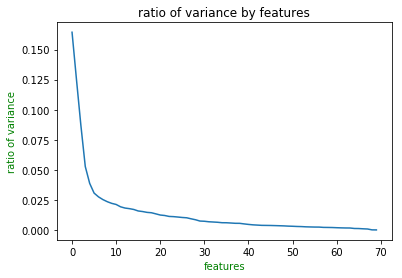

In [43]:
# Investigate the variance accounted for by each principal component. 

#print(pca.explained_variance_ratio_)
#print(pca.explained_variance_)
pca_variance = pca.explained_variance_ratio_

plt.plot(pca_variance)
plt.xlabel('features',color='g')
plt.ylabel('ratio of variance',color='g')
plt.title("ratio of variance by features") #标题
plt.show()

可以看出前10个feature能描述大部分的数据，但是具体多少个feature可以描述80%或者90%的数据呢？ 这时需要用到累计：

[ 0.16440531  0.28967312  0.37676238  0.42949502  0.46818565  0.49881022
  0.52629642  0.55151264  0.57496459  0.59703888  0.61819844  0.63742303
  0.65561528  0.67330422  0.69030044  0.70606062  0.72134002  0.73593186
  0.75021178  0.76355871  0.77593762  0.7879329   0.79915274  0.81019874
  0.82090701  0.83124832  0.84133525  0.85056353  0.85901107  0.86638273
  0.87358499  0.88036954  0.88694534  0.89330098  0.89929237  0.90524855
  0.91098847  0.91649231  0.9219669   0.92696687  0.93154083  0.93576801
  0.93977667  0.94357007  0.94731836  0.95100963  0.95460148  0.95807903
  0.9614337   0.96459045  0.96762263  0.97048899  0.97326046  0.9758338
  0.97830119  0.98067927  0.98302959  0.98513186  0.98718777  0.98917429
  0.99100914  0.99271928  0.99433951  0.99593174  0.99713235  0.9982756
  0.99919799  0.99995836  1.          1.        ]


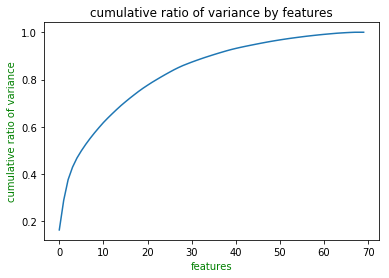

In [44]:
# cumulative ratio of variance by features 计算累计的variance
pca_variance_cum = np.cumsum(pca_variance)
print(pca_variance_cum)

plt.plot(pca_variance_cum)
plt.xlabel('features',color='g')
plt.ylabel('cumulative ratio of variance',color='g')
plt.title("cumulative ratio of variance by features") #标题
plt.show()

可以看出多少feature可以描述%多少的数据。也就是说如果要主成分至少占90%，需要n_components设置成多少。 
从上面的pca_variance_cum可以看出，前36个feature到达了90%

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain. **********

pca2 = PCA(n_components=24)
#pca2 = PCA(n_components=0.9) # 也可以不直接指定降维的维度，而指定降维后的主成分方差和比例（主成分至少占80%）
cleaned_azdias_pca = pca2.fit_transform(cleaned_azdias_ss)

In [47]:
pca_variance2 = pca2.explained_variance_ratio_
pca_variance_cum2 = np.cumsum(pca_variance2)
type(pca_variance_cum2)

numpy.ndarray

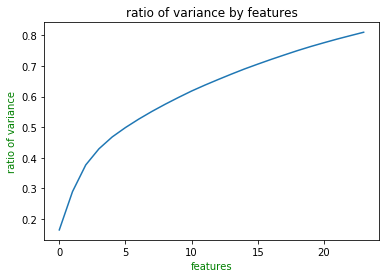

In [48]:
plt.plot(pca_variance_cum2)
plt.xlabel('features',color='g')
plt.ylabel('ratio of variance',color='g')
plt.title("ratio of variance by features") #标题
plt.show()

In [49]:
type(cleaned_azdias_pca)

numpy.ndarray

In [50]:
# cleaned_azdias_pca是narray型的，需要转换成dataframe，才可以存储成csv

# Dimension indexing 给每个主成分编个序号
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca2.components_)+1)]

# PCA components
cleaned_azdias_pca = pd.DataFrame(cleaned_azdias_pca, columns = dimensions)
#components.index = dimensions
cleaned_azdias_pca.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 15,Dimension 16,Dimension 17,Dimension 18,Dimension 19,Dimension 20,Dimension 21,Dimension 22,Dimension 23,Dimension 24
0,3.378002,-2.869707,-2.911388,-0.381118,-1.960993,2.663286,0.678347,1.335217,-0.834914,-0.283401,...,-1.490046,-2.524970,0.342041,-1.045763,10.795601,-0.204306,0.308033,0.919434,-1.465188,0.233069
1,-1.059077,0.299373,-3.049405,2.573384,-0.281601,0.510719,-1.179625,-0.246973,-0.969815,-0.541006,...,-0.442655,0.649028,-0.051911,1.443487,-0.074423,-1.323035,0.709989,-0.825043,1.106005,-0.330457
2,-4.064819,1.423593,-0.761893,-0.958422,-0.030780,-0.034768,0.486482,-0.367059,-0.688445,-0.090966,...,0.196309,-0.208214,0.381750,0.095502,-0.030460,-0.023951,-0.967532,0.636953,0.607677,0.808030
3,0.566722,0.340567,3.262919,0.834571,0.268476,-3.396851,-0.004784,1.968835,-0.491223,1.270355,...,0.430972,0.961591,-0.869701,-1.349154,-0.263245,-0.434277,-0.293821,-0.455106,0.011591,-1.451937
4,-1.161088,-1.431283,-1.080284,-1.859728,-3.198282,0.211772,-1.119702,-0.906919,1.660620,-2.253730,...,-0.589414,-0.512846,1.249144,0.204788,-0.011741,1.881637,-0.008121,-0.529640,-1.013691,-0.419449


In [51]:
cleaned_azdias_pca.to_csv('cleaned_azdias_pca.csv')

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I keept 24 principal components for the next step, as 24 of them can represent 80% of the total.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

针对每个主成分，研究它是由哪些feature组成的，以及每个feature的权重。

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
pca2.components_.shape

(24, 70)

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Dimension indexing 给每个主成分编个序号
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca2.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca2.components_, 4), columns = cleaned_azdias_ss.keys())
components.index = dimensions
components.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
Dimension 1,-0.1000,0.0081,-0.2037,0.1262,-0.0969,0.0525,0.0566,0.1603,-0.1009,0.0273,...,0.1344,-0.0776,0.0578,0.0307,0.0589,-0.0589,0.0824,-0.0986,0.2016,-0.1198
Dimension 2,0.2659,0.0821,0.0842,-0.2444,0.2374,-0.2099,-0.2312,0.1029,-0.0033,-0.0600,...,0.0554,0.0771,-0.0562,-0.0545,0.0261,-0.0261,-0.2553,-0.0017,0.0582,0.0114
Dimension 3,0.0736,-0.3699,0.1590,-0.1021,0.0948,-0.1841,-0.0945,-0.0500,0.0528,-0.0217,...,0.0272,0.0345,0.0170,-0.0457,0.0170,-0.0170,-0.1012,0.0506,0.0199,-0.0055
Dimension 4,-0.0418,0.0310,0.0585,-0.0005,0.0010,-0.1257,0.0977,-0.1124,0.3684,0.0096,...,0.0937,-0.0128,0.0158,-0.0032,-0.1861,0.1861,0.0365,0.3681,-0.1214,0.0514
Dimension 5,-0.0121,0.0247,0.0812,-0.0063,-0.1135,0.0539,-0.0660,-0.0504,0.1280,-0.0120,...,0.0694,0.0987,-0.0886,-0.0035,0.4030,-0.4030,0.0401,0.1231,-0.0590,0.0792


In [56]:
def interpret_component_X(components, X):
    '''
    Print the weights of feature names contributed to a principal component, sorted by weight. 
    Plots an image associated with this principal component to understand how the weighting of the features.
    INPUT: 
          components - the components dataframe built before, contain each component with linked feature weights
          X - the index name of components. i.e. 'Dimension 1', 'Dimension 2', 'Dimension 3'...
    OUTPUT
          None
    '''
    if X in components.index:
        components_X = components.loc[components.index == X].T  
        
        components_X_sort = components_X.sort_values([X], ascending=0)
        print('the top 10 positive weight features are: ')
        print(components_X_sort[0:10])
        components_X_sort = components_X.sort_values([X], ascending=1)
        print('the top 10 negative weight features are: ')
        print(components_X_sort[0:10])
        
        # draw the sorted feature weight
        ax = plt.figure(figsize=(8,15))

        x = components_X_sort[X]
        y = components_X_sort.index
        bar_height = 0.8

        # 绘图 y= y轴， left= 水平条的底部， height 水平条的宽度， width 水平条的长度
        plt.yticks(np.arange(len(y)), y)
        plt.barh(np.arange(len(y)), left=0, height=bar_height, width=x)
        plt.xlabel(X,color='g')
        plt.ylabel('features',color='g')

        # 在柱状图上显示具体数值, ha参数控制水平对齐方式, va控制垂直对齐方式
        for y, x in enumerate(x):
            plt.text(x, y-bar_height/2, '%s' % x, ha='center', va='bottom')

        # 展示图形
        plt.show()
              
    else:
        print('That is not the right input, please read the docstring before continuing.')
        

the top 10 positive weight features are: 
                    Dimension 1
PLZ8_ANTG3               0.2265
PLZ8_ANTG4               0.2213
PLZ8_BAUMAX              0.2170
wealth                   0.2016
ORTSGR_KLS9              0.1991
EWDICHTE                 0.1961
HH_EINKOMMEN_SCORE       0.1950
FINANZ_HAUSBAUER         0.1603
PLZ8_ANTG2               0.1522
KBA05_ANTG4              0.1510
the top 10 negative weight features are: 
                   Dimension 1
MOBI_REGIO             -0.2359
PLZ8_ANTG1             -0.2264
KBA05_ANTG1            -0.2193
KBA05_GBZ              -0.2118
FINANZ_MINIMALIST      -0.2037
PLZ8_GBZ               -0.1698
KONSUMNAEHE            -0.1673
INNENSTADT             -0.1655
BALLRAUM               -0.1278
life_stage             -0.1198


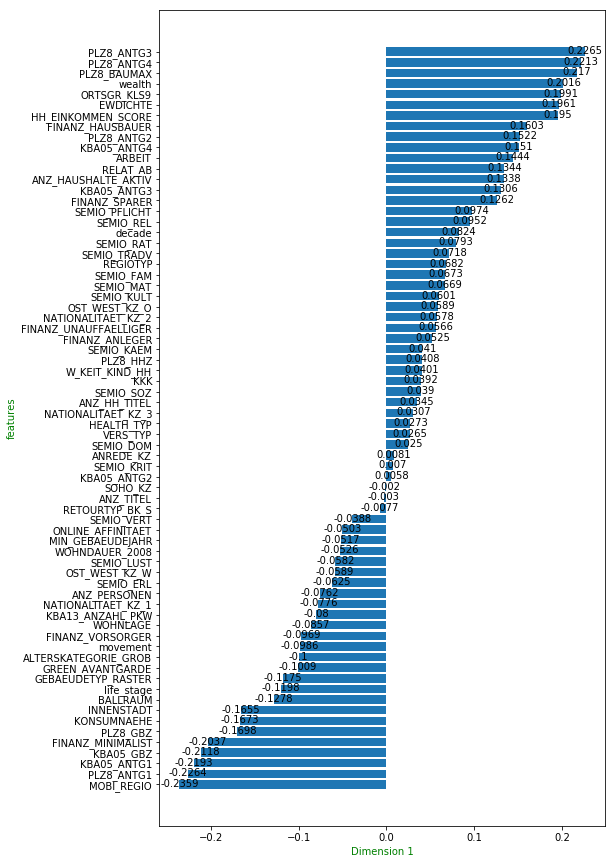

In [57]:
X = 'Dimension 1'
interpret_component_X(components, X)

the top 10 positive weight features are: 
                      Dimension 2
ALTERSKATEGORIE_GROB       0.2659
FINANZ_VORSORGER           0.2374
SEMIO_ERL                  0.2292
SEMIO_LUST                 0.1864
RETOURTYP_BK_S             0.1631
W_KEIT_KIND_HH             0.1163
SEMIO_KRIT                 0.1081
FINANZ_HAUSBAUER           0.1029
SEMIO_KAEM                 0.1025
FINANZ_MINIMALIST          0.0842
the top 10 negative weight features are: 
                       Dimension 2
SEMIO_REL                  -0.2588
decade                     -0.2553
FINANZ_SPARER              -0.2444
SEMIO_TRADV                -0.2350
SEMIO_PFLICHT              -0.2350
FINANZ_UNAUFFAELLIGER      -0.2312
SEMIO_KULT                 -0.2176
FINANZ_ANLEGER             -0.2099
SEMIO_FAM                  -0.1829
SEMIO_RAT                  -0.1786


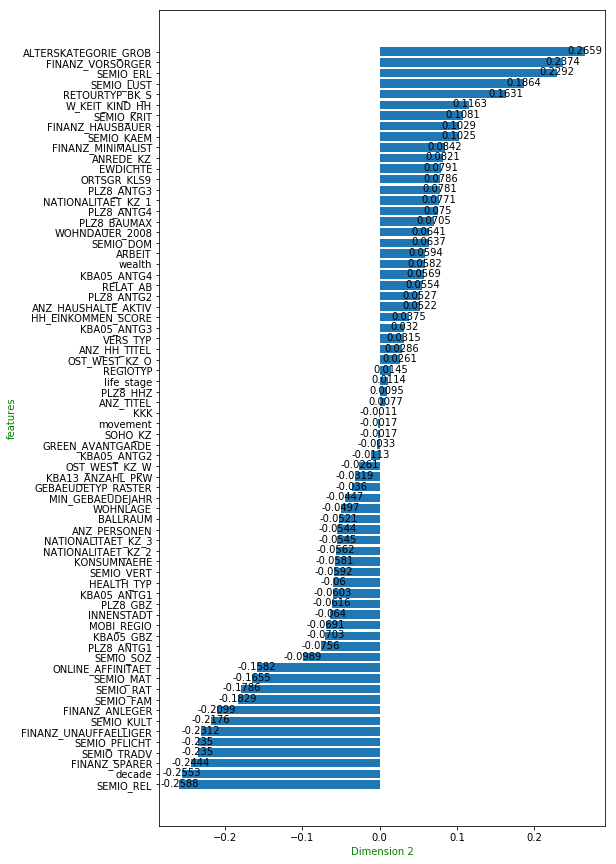

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

X = 'Dimension 2'
interpret_component_X(components, X)

the top 10 positive weight features are: 
                      Dimension 3
SEMIO_VERT                 0.3473
SEMIO_SOZ                  0.2640
SEMIO_FAM                  0.2522
SEMIO_KULT                 0.2387
FINANZ_MINIMALIST          0.1590
RETOURTYP_BK_S             0.1028
FINANZ_VORSORGER           0.0948
W_KEIT_KIND_HH             0.0849
ALTERSKATEGORIE_GROB       0.0736
SEMIO_REL                  0.0735
the top 10 negative weight features are: 
                       Dimension 3
ANREDE_KZ                  -0.3699
SEMIO_KAEM                 -0.3392
SEMIO_DOM                  -0.3143
SEMIO_KRIT                 -0.2781
SEMIO_RAT                  -0.2138
FINANZ_ANLEGER             -0.1841
SEMIO_ERL                  -0.1805
FINANZ_SPARER              -0.1021
decade                     -0.1012
FINANZ_UNAUFFAELLIGER      -0.0945


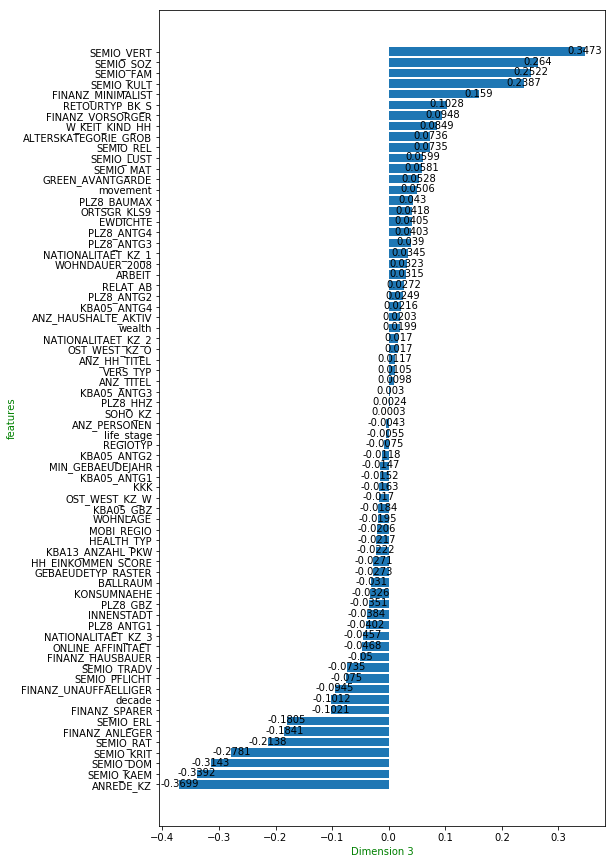

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

X = 'Dimension 3'
interpret_component_X(components, X)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Take "Dimension 3" for example, the top 4 positive weights are from Personality typology features, which means dreamful, socially-minded, family-minded and cultural-minded got higher score (even it means low affinity), the dimension get higher score. However, the top 1 negative weight is FINANZ_UNAUFFAELLIGER, which means financial typology, if it got higher score, it will drive the Dimension score down. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
# Loading...PCA processed data 
cleaned_azdias_pca = pd.read_csv('cleaned_azdias_pca.csv', sep = ',')
cleaned_azdias_pca.drop(cleaned_azdias_pca.columns[0], axis=1, inplace=True)

In [61]:
cleaned_azdias_pca.shape

(794792, 24)

In [62]:
# Over a number of different cluster counts...
start = time.time()
scores = []
clusters = list(range(2,13))

for i in clusters:
    
    start_i = time.time()
    # run k-means clustering on the data and...
    km = KMeans(n_clusters=i)
    km.fit(cleaned_azdias_pca)

    # compute the average within-cluster distances.
    #score = abs(model.score(cleaned_azdias_pca))
    score = km.inertia_
    print(score)
    scores.append(score)
    # compute the Calinski-Harabasz Index. 分数值越大则聚类效果越好
    #ch_scores.append(metrics.calinski_harabaz_score(cleaned_azdias_pca, model))
    
    end_i = time.time() - start_i
    print("K-means process time for {:.0f} clusters: {:.0f}m {:.0f}s".format(i, end_i//60, end_i % 60))


Kmeans_time = time.time() - start
print("Total time: {:.0f}m {:.0f}s".format(Kmeans_time//60, Kmeans_time % 60))


38217444.4616
K-means process time for 2 clusters: 0m 23s
34993140.333
K-means process time for 3 clusters: 0m 55s
32754112.6375
K-means process time for 4 clusters: 0m 40s
31277749.7293
K-means process time for 5 clusters: 0m 54s
30048203.3827
K-means process time for 6 clusters: 0m 53s
28933458.8841
K-means process time for 7 clusters: 0m 60s
28094859.0464
K-means process time for 8 clusters: 1m 14s
27425455.4744
K-means process time for 9 clusters: 1m 24s
26842976.4818
K-means process time for 10 clusters: 1m 48s
26374310.2708
K-means process time for 11 clusters: 1m 60s
25736037.5734
K-means process time for 12 clusters: 1m 52s
Total time: 13m 4s


Text(0.5,1,'model score on K centers')

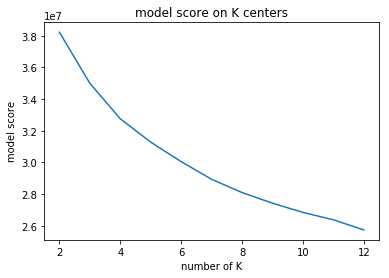

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters, scores)
plt.xlabel('number of K')
plt.ylabel('model score')
plt.title('model score on K centers')

###didn't see any elbow from the score trend on K centers above...

In [64]:
# Evaluate by Calinski-Harabasz Index 分数值越大则聚类效果越好
start = time.time()
ch_scores = []
clusters = list(range(2,14))

for i in clusters:
    
    start_i = time.time()
    # run k-means clustering on the data and...
    model = KMeans(n_clusters=i)
    labels = model.fit_predict(cleaned_azdias_pca)

    # compute the Calinski-Harabasz Index.
    score = metrics.calinski_harabaz_score(cleaned_azdias_pca, labels)
    print(score)
    ch_scores.append(score)
    
    end_i = time.time() - start_i
    print("K-means process time for {:.0f} clusters: {:.0f}m {:.0f}s".format(i, end_i//60, end_i % 60))


Kmeans_time = time.time() - start
print("Total time: {:.0f}m {:.0f}s".format(Kmeans_time//60, Kmeans_time % 60))


142629.13301
K-means process time for 2 clusters: 0m 19s
114501.983524
K-means process time for 3 clusters: 0m 53s
99662.8265202
K-means process time for 4 clusters: 0m 36s
87654.1551242
K-means process time for 5 clusters: 0m 50s
79394.2678305
K-means process time for 6 clusters: 1m 4s
73903.296909
K-means process time for 7 clusters: 1m 5s
68625.4094405
K-means process time for 8 clusters: 1m 3s
63937.6988585
K-means process time for 9 clusters: 1m 37s
59982.9715465
K-means process time for 10 clusters: 1m 51s
57256.9636384
K-means process time for 11 clusters: 1m 47s
54412.4587006
K-means process time for 12 clusters: 2m 6s
51462.1908947
K-means process time for 13 clusters: 2m 36s
Total time: 15m 47s


###calinski_harabaz index suppose to be the bigger the better. But why it also dropping while n_clusters increase...? the trend is very similiar as using .score() to evaluate...

Text(0.5,1,'model score on K centers')

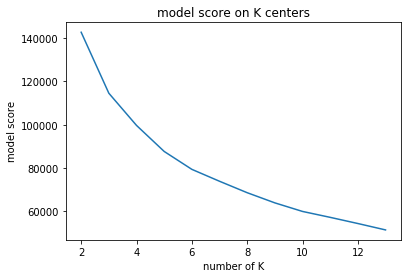

In [65]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(clusters, ch_scores)
plt.xlabel('number of K')
plt.ylabel('model score')
plt.title('model score on K centers')

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

i = 5
start_i = time.time()

model = KMeans(n_clusters=i)
labels = model.fit_predict(cleaned_azdias_pca)

# compute the average within-cluster distances.
score = abs(model.score(cleaned_azdias_pca))
print(score)
# compute the Calinski-Harabasz Index. 分数值越大则聚类效果越好
ch_score = metrics.calinski_harabaz_score(cleaned_azdias_pca, labels) 
print(ch_score)

end_i = time.time() - start_i
print("K-means process time for {:.0f} clusters: {:.0f}m {:.0f}s".format(i, end_i//60, end_i % 60))

31277737.272
87654.1575961
K-means process time for 5 clusters: 0m 49s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I have decided to use 5 clusters. Actually I tried 3-6 clusters, and Compare Customer Data to Demographics Data in Step3.3 using .countplot(), 5 looks better to find overrepresented and underrepresented. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [8]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.shape

(191652, 85)

In [9]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

start = time.time()
customers_cleaned, subset1_customers = clean_data(customers)
print("Finish clean df!! new shape is : {0}".format(customers_cleaned.shape))
clean_time = time.time() - start
print("Total time: {:.0f}m {:.0f}s".format(clean_time//60, clean_time % 60))

customers_cleaned.to_csv('customers_cleaned.csv')
subset1_customers.to_csv('subset1_customers.csv')

finish isin check
finish replacing missing data with NaN
These columns have too much missing data: 
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Drop these columns...and the df shape become: (191652, 79)
Keep the rows which have less than 17.0 NaN...and the df shape become: (141226, 79)
Drop the rows which have more than 17.0 NaN...the dropped subset1 shape is: (50426, 79)
Drop the column due to too many values: 
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Re-encode the multiple value column with OneHot: NATIONALITAET_KZ, OST_WEST_KZ
Finish deal with categorical columns...and the df shape become: (141226, 70)
Finish re-engineer "PRAEGENDE_JUGENDJAHRE" column...and the df shape become: (141226, 71)
Finish re-engineer "CAMEO_INTL_2015" column...and the df shape become: (141226, 72)
Drop "LP_LE

In [71]:
# Loading...cleaned customers data
customers_cleaned = pd.read_csv('customers_cleaned.csv', sep = ',')
customers_cleaned.drop(customers_cleaned.columns[0], axis=1, inplace=True)
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,1,0,0,0,1,50.0,1.0,1.0,3.0
1,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,1,0,0,0,1,50.0,1.0,3.0,4.0
2,4.0,1,5,1,5,2,1,2,0,2.0,...,1.0,1,0,0,0,1,40.0,0.0,2.0,4.0
3,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,1,0,0,0,1,70.0,0.0,4.0,1.0
4,3.0,1,5,1,5,1,2,3,1,3.0,...,5.0,1,0,0,0,1,50.0,1.0,3.0,4.0


In [72]:
# Use Imputer to fill the NaN values using old object - imp

df_imp = imp.transform(customers_cleaned)
column_names = customers_cleaned.columns
index_names = customers_cleaned.index
customers_wona = pd.DataFrame(df_imp, index=index_names, columns=column_names)
customers_wona.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,50.0,1.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,3.0,1.0,0.0,0.0,0.0,1.0,50.0,1.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,1.0,40.0,0.0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,1.0,0.0,0.0,0.0,1.0,70.0,0.0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.0,1.0,0.0,0.0,0.0,1.0,50.0,1.0,3.0,4.0


In [73]:
# 检查是否还存在空值（NaN）
data = customers_wona

# 看有多少列有空值
df_column = data.isna().sum().to_frame()
df_column.columns = ['nan_sum']
print(len(df_column.loc[df_column['nan_sum'] > 0].index))

# 看有多少行有空值
df_row = data.isna().sum(axis=1).to_frame()
df_row.columns = ['nan_sum']
print(len(df_row.loc[df_row['nan_sum'] > 0].index))

0
0


In [74]:
# Apply feature scaling to the customers data using old object - ss

df_ss = ss.transform(customers_wona)
customers_ss = pd.DataFrame(df_ss, index=index_names, columns=column_names)
customers_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,1.184675,-1.043789,1.410069,-1.155021,1.137682,-1.250022,-0.467467,-0.796083,1.884210,-1.626618,...,-1.527492,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-1.628188,1.874477,-1.549439,0.085902
1,1.184675,0.958048,1.410069,-1.155021,1.137682,-1.250022,0.962660,0.625786,1.884210,-0.271122,...,-0.053369,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-1.628188,1.874477,-0.180156,0.761142
2,1.184675,-1.043789,1.410069,-1.155021,1.137682,-0.570964,-1.182530,-0.796083,-0.530726,-0.271122,...,-1.527492,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-2.326754,-0.552999,-0.864798,0.761142
3,0.201154,-1.043789,-0.041731,-1.155021,0.411387,0.787152,1.677723,-0.796083,-0.530726,1.084374,...,-1.527492,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-0.231057,-0.552999,0.504486,-1.264578
4,0.201154,-1.043789,1.410069,-1.155021,1.137682,-1.250022,-0.467467,-0.085148,1.884210,1.084374,...,1.420755,0.440721,-0.294636,-0.206286,-0.517757,0.517757,-1.628188,1.874477,-0.180156,0.761142


In [75]:
# Apply PCA to the customers data using old object - pca2

customers_pca = pca2.transform(customers_ss)

# customers_pca是narray型的，需要转换成dataframe，才可以存储成csv

# Dimension indexing 给每个主成分编个序号(前面已经有了)
#dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca2.components_)+1)]

# PCA components
customers_pca = pd.DataFrame(customers_pca, columns = dimensions)
#components.index = dimensions
customers_pca.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 15,Dimension 16,Dimension 17,Dimension 18,Dimension 19,Dimension 20,Dimension 21,Dimension 22,Dimension 23,Dimension 24
0,-5.930096,1.182839,4.291963,1.848976,-1.884520,2.756116,-1.278423,-0.945603,-0.622630,1.103456,...,-0.869812,0.931453,0.413218,0.669769,-0.100341,-0.349063,0.387269,0.006806,0.586734,-1.185361
1,-1.078883,5.119794,-0.663478,2.433290,0.554168,-1.282557,0.400582,-0.651672,-0.796446,-0.158038,...,-0.364677,0.072653,1.712093,1.364190,0.067993,0.142166,-0.314125,-1.612440,-1.201272,0.040233
2,-4.547772,0.521247,2.692046,-2.452362,-1.320646,0.769059,0.905135,-1.037858,-0.398462,-0.341891,...,-0.369616,0.372293,0.351798,0.093579,-0.032915,0.881994,-0.652662,-0.002162,0.761016,1.102297
3,1.382891,-0.868031,1.191304,-0.283369,-0.950543,-2.062231,0.342210,1.408107,-1.212935,2.024222,...,-0.134921,1.939119,-0.170430,-0.195444,-0.223670,-0.578187,1.245042,-0.949188,-0.206729,-0.334012
4,-2.272340,1.592054,2.896889,3.348200,-1.425382,0.205346,-1.628485,0.994057,0.770595,-0.553674,...,-0.167417,-1.855621,1.541523,0.303974,-0.006946,1.255561,-0.072202,-0.650853,-0.650293,0.745588


In [77]:
# customers_pca是narray型的，需要转换成dataframe，才可以存储成csv
customers_pca = pd.DataFrame(customers_pca, columns = dimensions)
#components.index = dimensions
customers_pca.to_csv('customers_pca.csv')
print(customers_pca.shape)

(141226, 24)


In [78]:
# Loading...customers_pca data
customers_pca = pd.read_csv('customers_pca.csv', sep = ',')
customers_pca.drop(customers_pca.columns[0], axis=1, inplace=True)
customers_pca.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 15,Dimension 16,Dimension 17,Dimension 18,Dimension 19,Dimension 20,Dimension 21,Dimension 22,Dimension 23,Dimension 24
0,-5.930096,1.182839,4.291963,1.848976,-1.884520,2.756116,-1.278423,-0.945603,-0.622630,1.103456,...,-0.869812,0.931453,0.413218,0.669769,-0.100341,-0.349063,0.387269,0.006806,0.586734,-1.185361
1,-1.078883,5.119794,-0.663478,2.433290,0.554168,-1.282557,0.400582,-0.651672,-0.796446,-0.158038,...,-0.364677,0.072653,1.712093,1.364190,0.067993,0.142166,-0.314125,-1.612440,-1.201272,0.040233
2,-4.547772,0.521247,2.692046,-2.452362,-1.320646,0.769059,0.905135,-1.037858,-0.398462,-0.341891,...,-0.369616,0.372293,0.351798,0.093579,-0.032915,0.881994,-0.652662,-0.002162,0.761016,1.102297
3,1.382891,-0.868031,1.191304,-0.283369,-0.950543,-2.062231,0.342210,1.408107,-1.212935,2.024222,...,-0.134921,1.939119,-0.170430,-0.195444,-0.223670,-0.578187,1.245042,-0.949188,-0.206729,-0.334012
4,-2.272340,1.592054,2.896889,3.348200,-1.425382,0.205346,-1.628485,0.994057,0.770595,-0.553674,...,-0.167417,-1.855621,1.541523,0.303974,-0.006946,1.255561,-0.072202,-0.650853,-0.650293,0.745588


In [79]:
labels_cust = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

分析两组数据的聚类情况。如果某一类在customer data里的占比很高，但是在general data里占比一般，说明这是customer里有特点的人群，是我们的target用户（差越大，说明越有代表性）；反之，如果某一类在customer data里的占比比在general data里占比低很多，说明不是target人群。
注意，也可以考虑之前在step 1.1.3 删除的missing value很多的人群，说不定也有这个特征。

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

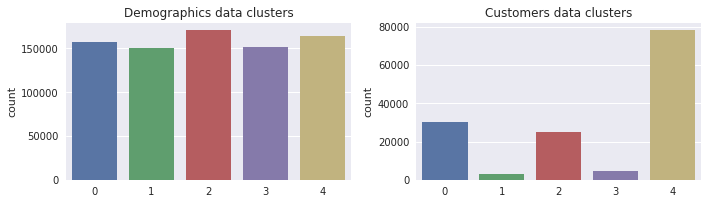

In [80]:
plt.figure(figsize=(10, 3))
sns.set(style="darkgrid")

# draw subset1
ax1=plt.subplot(1, 2, 1)
ax1.set_title('Demographics data clusters')
ax1 = sns.countplot(x =labels)

# draw customers data clusters
ax2=plt.subplot(1, 2, 2)
ax2.set_title('Customers data clusters')
ax2 = sns.countplot(x=labels_cust)

plt.tight_layout()
plt.show()

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

labels_cust_df = pd.DataFrame(labels_cust, index = customers_pca.index, columns = ['cluster'])
#labels_cust_df.head()
labels_cust_1_index = labels_cust_df.loc[labels_cust_df['cluster'] == 4].index
#labels_cust_1_index[:20]
customers_pca_1 = customers_pca.loc[labels_cust_1_index]
customers_pca_1[:5]

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 15,Dimension 16,Dimension 17,Dimension 18,Dimension 19,Dimension 20,Dimension 21,Dimension 22,Dimension 23,Dimension 24
0,-5.930096,1.182839,4.291963,1.848976,-1.884520,2.756116,-1.278423,-0.945603,-0.622630,1.103456,...,-0.869812,0.931453,0.413218,0.669769,-0.100341,-0.349063,0.387269,0.006806,0.586734,-1.185361
2,-4.547772,0.521247,2.692046,-2.452362,-1.320646,0.769059,0.905135,-1.037858,-0.398462,-0.341891,...,-0.369616,0.372293,0.351798,0.093579,-0.032915,0.881994,-0.652662,-0.002162,0.761016,1.102297
4,-2.272340,1.592054,2.896889,3.348200,-1.425382,0.205346,-1.628485,0.994057,0.770595,-0.553674,...,-0.167417,-1.855621,1.541523,0.303974,-0.006946,1.255561,-0.072202,-0.650853,-0.650293,0.745588
5,-5.792490,0.843962,2.927329,1.269072,-1.385937,1.808167,-0.467870,0.216886,0.631633,-0.072241,...,-0.808302,-0.287349,0.993676,0.449477,-0.067531,0.733740,0.775708,0.397649,0.287487,0.187011
6,-4.510210,1.687609,4.492223,2.592011,0.894285,0.735579,-0.842485,-2.295111,-0.983617,0.576953,...,-0.442965,-0.373189,0.211529,0.051782,-0.083651,0.117429,-0.876628,-0.549493,-0.141591,-0.273806


In [82]:
customers_ss_1 = pca2.inverse_transform(customers_pca_1)
customers_ss_1 = pd.DataFrame(customers_ss_1, index = customers_pca_1.index, columns=column_names)
customers_ss_1[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,1.487044,-1.318964,1.515419,-1.247556,1.112818,-1.465030,-0.569907,-0.508300,1.827757,-1.376981,...,-2.343869,0.366912,-0.435237,-0.257495,-0.520994,0.520994,-1.238095,1.863287,-1.154588,0.284079
2,0.660572,-0.889942,1.458687,-1.340076,1.259797,-0.891121,-1.013176,-0.575899,-0.589590,-0.419124,...,-1.436349,0.562176,-0.259227,-0.274302,-0.625053,0.625053,-1.229399,-0.624068,-0.783512,0.623066
4,0.190867,-0.878938,1.181578,-1.207232,1.319283,-1.347644,-0.774458,-0.249985,2.300391,0.686417,...,1.097089,0.561267,-0.180055,-0.164543,-0.675980,0.675980,-0.979158,2.260533,-0.488278,1.031988
5,0.791708,-0.829870,1.728611,-1.477823,1.373365,-1.194564,-1.035653,-0.595416,1.810552,-0.520330,...,-1.308025,0.495519,-0.380074,-0.065566,-0.400398,0.400398,-1.262097,1.790842,-0.902266,0.136300
6,1.246301,-1.236057,1.552205,-1.320439,1.102343,-1.695507,-0.470959,-0.483309,1.968309,-1.665087,...,-0.133446,0.375393,-0.310204,-0.259161,-0.473606,0.473606,-1.282376,1.988673,-1.310605,1.469380


In [83]:
customers_ss_1.mean().sort_values(ascending = False)

FINANZ_MINIMALIST        1.346432
SEMIO_VERT               1.038536
FINANZ_VORSORGER         0.960120
GREEN_AVANTGARDE         0.960061
movement                 0.943627
KBA05_ANTG1              0.815197
MOBI_REGIO               0.802659
KBA05_GBZ                0.684722
ANZ_PERSONEN             0.669037
ALTERSKATEGORIE_GROB     0.651115
PLZ8_ANTG1               0.547550
SEMIO_LUST               0.537833
SEMIO_SOZ                0.527464
life_stage               0.471876
WOHNDAUER_2008           0.459707
PLZ8_GBZ                 0.453160
RETOURTYP_BK_S           0.428007
OST_WEST_KZ_W            0.417599
NATIONALITAET_KZ_1       0.389767
SEMIO_FAM                0.327941
SEMIO_KULT               0.313045
KONSUMNAEHE              0.307100
GEBAEUDETYP_RASTER       0.284055
ANZ_TITEL                0.274785
KBA13_ANZAHL_PKW         0.256503
INNENSTADT               0.249168
ONLINE_AFFINITAET        0.230412
BALLRAUM                 0.127351
SOHO_KZ                  0.013395
PLZ8_HHZ      

In [85]:
customers_wona_1 = ss.inverse_transform(customers_ss_1)
customers_wona_1 = pd.DataFrame(customers_wona_1, index = customers_ss_1.index, columns=column_names)
customers_wona_1[:5]


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,4.307434,0.862539,5.145130,0.862562,4.965766,0.683374,1.856740,2.404795,0.976623,1.184166,...,-0.107610,0.972761,-0.038117,-0.010133,-0.001322,1.001322,55.584203,0.995390,1.576728,3.293491
2,3.467116,1.076853,5.066976,0.725148,5.168134,1.528529,1.236839,2.309711,-0.024375,1.890813,...,1.123657,1.044822,0.009600,-0.013458,-0.043809,1.043809,55.708686,-0.029277,2.118727,3.795515
4,2.989541,1.082350,4.685230,0.922454,5.250037,0.856239,1.570681,2.768141,1.172336,2.706412,...,4.560871,1.044487,0.031063,0.008260,-0.064603,1.064603,59.290901,1.159036,2.549952,4.401110
5,3.600448,1.106862,5.438823,0.520559,5.324501,1.081670,1.205404,2.282259,0.969499,1.816150,...,1.297759,1.020223,-0.023162,0.027844,0.047918,0.952082,55.240611,0.965546,1.945274,3.074637
6,4.062658,0.903954,5.195807,0.754314,4.951344,0.343966,1.995116,2.439947,1.034824,0.971620,...,2.891356,0.975891,-0.004221,-0.010462,0.018027,0.981973,54.950316,1.047043,1.348845,5.048868


In [87]:
overrepresented_features = ['FINANZ_MINIMALIST', 'SEMIO_VERT', 'FINANZ_VORSORGER', 'GREEN_AVANTGARDE', 'movement', 
                            'ANREDE_KZ', 'SEMIO_KAEM', 'HH_EINKOMMEN_SCORE', 'FINANZ_SPARER', 'FINANZ_ANLEGER']
customers_wona_1[overrepresented_features].mean()

FINANZ_MINIMALIST     4.912334
SEMIO_VERT            6.294110
FINANZ_VORSORGER      4.755523
GREEN_AVANTGARDE      0.617320
movement              0.616536
ANREDE_KZ             1.059715
SEMIO_KAEM            2.562479
HH_EINKOMMEN_SCORE    2.828850
FINANZ_SPARER         1.176029
FINANZ_ANLEGER        1.273684
dtype: float64

In [88]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

labels_df = pd.DataFrame(labels, index = cleaned_azdias_pca.index, columns = ['cluster'])

labels_1_index = labels_df.loc[labels_df['cluster'] == 1].index

azdias_pca_1 = cleaned_azdias_pca.loc[labels_1_index]
azdias_pca_1[:5]

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 15,Dimension 16,Dimension 17,Dimension 18,Dimension 19,Dimension 20,Dimension 21,Dimension 22,Dimension 23,Dimension 24
0,3.378002,-2.869707,-2.911388,-0.381118,-1.960993,2.663286,0.678347,1.335217,-0.834914,-0.283401,...,-1.490046,-2.524970,0.342041,-1.045763,10.795601,-0.204306,0.308033,0.919434,-1.465188,0.233069
17,4.120889,-2.894230,3.640014,1.068636,-0.412737,-2.034570,-1.085052,0.826167,-0.372899,-1.066942,...,0.559338,-0.182075,-0.384833,-0.568074,-0.058803,-0.559378,-2.256608,-1.288298,-0.885653,0.462677
18,4.015029,-4.281996,2.077776,-1.143946,-1.572228,-1.928425,-0.920075,0.637478,-1.406357,-1.725982,...,0.229648,-0.539130,-0.251525,-0.834794,-0.090755,1.362526,0.709534,-0.176392,-1.127200,-0.658191
24,6.836519,-0.881886,-2.350205,1.196133,-0.288791,-1.604687,-1.468234,-0.704258,-1.585714,-0.669856,...,-0.104817,0.646214,0.209100,0.561373,-0.073893,-0.316739,-0.012723,0.355010,0.418846,1.539125
26,3.642185,0.314327,-2.011827,3.667882,-0.874852,-0.101565,-0.167003,-2.727793,2.077110,2.755908,...,-0.189270,-0.226643,-2.603746,-0.133466,-0.095432,0.261591,0.020883,0.671612,-1.367581,-0.415811


In [89]:
azdias_ss_1 = pca2.inverse_transform(azdias_pca_1)
azdias_ss_1 = pd.DataFrame(azdias_ss_1, index = azdias_pca_1.index, columns=column_names)
azdias_ss_1[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,-1.662411,0.830886,-1.916949,1.497377,-0.881089,1.403752,1.048189,1.102216,-0.429727,0.871490,...,0.867670,0.442984,-0.361074,-0.285296,-0.617032,0.617032,1.373742,-0.425277,1.018121,-0.957679
17,-1.037617,-1.577180,-0.173896,0.992148,-1.005332,0.238123,1.177730,-0.564432,-0.709976,0.092875,...,1.644391,0.399369,-0.350319,-0.384846,-0.393555,0.393555,0.878126,-0.707069,0.212937,0.603068
18,-1.405103,-1.145437,-1.455379,1.588254,-0.979384,1.103785,1.357180,1.029477,-0.505153,-0.333629,...,1.094164,0.357445,-0.380590,-0.188909,-0.590738,0.590738,1.252373,-0.503566,1.223405,-0.883384
24,-1.089136,1.150419,-1.786472,1.185007,-1.004730,0.689163,1.129413,1.021647,-0.368641,-0.981891,...,1.141919,0.489528,-0.562072,-0.262678,-0.493426,0.493426,0.868779,-0.367377,1.189464,-0.900848
26,-0.773647,1.004902,-0.437410,-0.185591,0.399038,-0.841640,-0.280994,0.609835,-0.314311,0.109183,...,1.008748,-2.422883,3.020046,-0.282190,-0.567240,0.567240,-0.265140,-0.298181,0.374981,-0.517284


In [90]:
azdias_ss_1.mean().sort_values(ascending = False)

FINANZ_SPARER            1.040470
SEMIO_REL                0.912458
SEMIO_PFLICHT            0.904147
PLZ8_ANTG3               0.874287
PLZ8_ANTG4               0.864564
PLZ8_BAUMAX              0.853929
decade                   0.848330
wealth                   0.784503
SEMIO_TRADV              0.778584
HH_EINKOMMEN_SCORE       0.767467
ORTSGR_KLS9              0.758517
SEMIO_RAT                0.749549
EWDICHTE                 0.741890
FINANZ_UNAUFFAELLIGER    0.720299
FINANZ_ANLEGER           0.660410
SEMIO_KULT               0.622967
SEMIO_MAT                0.607826
SEMIO_FAM                0.579307
PLZ8_ANTG2               0.578918
FINANZ_HAUSBAUER         0.565150
KBA05_ANTG4              0.547348
KBA05_ANTG3              0.516151
ARBEIT                   0.516069
RELAT_AB                 0.492196
ANZ_HAUSHALTE_AKTIV      0.464088
NATIONALITAET_KZ_2       0.438476
SEMIO_SOZ                0.312574
REGIOTYP                 0.283382
NATIONALITAET_KZ_3       0.254567
OST_WEST_KZ_O 

In [91]:
azdias_wona_1 = ss.inverse_transform(azdias_ss_1)
azdias_wona_1 = pd.DataFrame(azdias_wona_1, index = azdias_ss_1.index, columns=column_names)
azdias_wona_1[:5]


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,RELAT_AB,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,1.105213,1.936477,0.416701,4.939464,2.220454,4.908021,4.119611,4.670146,0.041823,2.842947,...,4.249608,1.000835,-0.018011,-0.015633,-0.040534,1.040534,92.972778,0.052615,4.750224,1.454504
17,1.740474,0.733549,2.817931,4.189074,2.049389,3.191485,4.300771,2.325840,-0.074226,2.268534,...,5.303416,0.984740,-0.015096,-0.035331,0.050712,0.949288,85.878007,-0.063469,3.574158,3.765900
18,1.366832,0.949223,1.052560,5.074439,2.085116,4.466282,4.551727,4.567831,0.010590,1.953886,...,4.556901,0.969268,-0.023302,0.003438,-0.029798,1.029798,91.235365,0.020364,5.050067,1.564532
24,1.688093,2.096097,0.596445,4.475518,2.050218,3.855698,4.233201,4.556818,0.067118,1.475639,...,4.621693,1.018012,-0.072502,-0.011158,0.009934,0.990066,85.744210,0.076467,5.000491,1.538668
26,2.008867,2.023406,2.454913,2.439841,3.982998,1.601395,2.260778,3.977563,0.089615,2.280565,...,4.441014,-0.056786,0.898615,-0.015019,-0.020204,1.020204,69.512102,0.104972,3.810842,2.106709


In [93]:
# 取原值的平均数
underrepresented_features = ['FINANZ_SPARER', 'SEMIO_REL', 'SEMIO_PFLICHT', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 
                            'PLZ8_ANTG1', 'MOBI_REGIO','FINANZ_VORSORGER','ALTERSKATEGORIE_GROB','FINANZ_MINIMALIST']
azdias_wona_1[underrepresented_features].mean()


FINANZ_SPARER           4.260845
SEMIO_REL               5.736309
SEMIO_PFLICHT           5.863360
PLZ8_ANTG3              2.447172
PLZ8_ANTG4              1.319845
PLZ8_ANTG1              1.420148
MOBI_REGIO              1.737177
FINANZ_VORSORGER        2.209870
ALTERSKATEGORIE_GROB    1.831354
FINANZ_MINIMALIST       1.540344
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### People who are relatively popular with the mail-order company have below features:
|feature describe|value means|
|----|----|
|low financial interest                  | very low                         |
|Personality typology,  dreamful：          | very low affinity                |
| Financial typology, be prepared：          | very low                         |
| member of green avantgarde\(0 or 1\)：     | member of green avantgarde       |
| avantgarde\(1\) or mainstream\(0\)：       | avantgarde                       |
| Gender: 1: male, 2: female：               | male                             |
| Personality typology, combative attitude: | very high affinity~high affinity |
| Estimated household net income:           | very high income                 |
| Financial typology, money\-saver:         | very high                        |
| Financial typology, investor:             | very high                        |


#### People who are relatively unpopular with the mail-order company have below features:
| feature describe                                 | value means                         |
|:------------------------------------------------:|:-----------------------------------:|
| Financial typology, money\-saver：                | low                                 |
| Personality typology, religious：                 | low~very low affinity               |
| Personality typology, dutiful：                   | low~very low affinity               |
| Number of 6\-10 family houses in the PLZ8 region | average share of 6\-10 family homes |
| Number of 10\+ family houses in the PLZ8 region： | lower share of 10\+ family homes    |
| Number of 1\-2 family houses in the PLZ8 region： | lower share of 1\-2 family homes    |
| Movement patterns：                               | high movement                       |
| Financial typology, money\-saver：                | be prepared                         |
| Estimated age based on given name analysis：      | < 30 years old ～ 30 \- 45 years old |
| low financial interest：                          | high                                |


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.